# To do: 


In [1]:
import plotly
plotly.__version__

'5.3.1'

In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, make_scorer, auc, plot_roc_curve
from sklearn import svm
import seaborn as sns
#import umap


from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
!jupyter nbconvert --to script 'helper_functions.ipynb'
%run helper_functions.py

[NbConvertApp] Converting notebook helper_functions.ipynb to script
[NbConvertApp] Writing 7713 bytes to helper_functions.py


In [4]:
# Pandas settings
pd.set_option("display.max_rows", 100) 
pd.set_option("display.max_columns", 100) 
pd.set_option('display.notebook_repr_html', True) 
pd.set_option('display.latex.longtable', True)
pd.DataFrame._repr_latex_ = lambda self: r"\begin{footnotesize}\centering{%s}\end{footnotesize}" % self.to_latex()

# 1. Import and combine data

In [4]:
filenames_input=['Anthropometrics and cardiac risk factors.csv',
           'sociodem_socioeco.csv',
           'Home locations.csv',
           'Baseline Medical Conditions.csv',
           'PollutantsAndEnv.csv']   
path=r'tidy_data_tiles/'

df_input,df_label,df_date_assessment=load_data(path,filenames_input)
    

Time to read the data: 35.83155182749033
All consented individuals:  502527


In [5]:
ukbd=UKBB_DATA(df_input,df_label,df_date_assessment)
#del df_input,df_label,df_date_assessment
ukbd.drop_lost_to_follow_up()

# drop baseline medCons while only keeping Exclude_baseline_MedCon
ukbd.df_input.drop(columns=list(set(ukbd.selected_categories_tidy_columns['Baseline Medical conditions']['col_name'])-set(['Exclude_baseline_MedCon'])),inplace=True)

#rename columns
rename_cols_names_dict={v['col_name'][0]:k for k,v in ukbd.selected_categories_tidy_columns.items() if len(v['col_name'])==1}
ukbd.df_input.rename(columns=rename_cols_names_dict,inplace=True)

#drop columns
ukbd.df_input.drop(columns=['Home_Longitude','Home_Latitude','myasthenia gravis.1'],inplace=True)
#drop columns rows with nan
ukbd.df_input.dropna(inplace=True)
#align the indices of input and labels
ukbd.df_label=ukbd.df_label.iloc[ukbd.df_input.index]

print("population size after dropping nans is:  {}".format(ukbd.df_input.shape))
print("population size after excluding those with preexisting:  {}".format(ukbd.df_input.shape[0]-ukbd.df_label["Exclude_outcomes"].sum()))

1298 individuals lost to follow up and were excluded
the remaining number of individuals is (501229, 518)
population size after dropping nans is:  (431961, 91)
population size after excluding those with preexisting:  424158


## 2 Exclusions

In [8]:
#remove exclusion flag based on baseline medical condition for mortality as the outcome
ukbd.selected_categories_exclusions.remove('Exclude_baseline_MedCon')
ukbd.selected_outcome_categories_exclusions.remove('Exclude_outcomes')

ukbd.apply_exclusions()
ukbd.prepare_mortality_outcomes()

Applying exclusion based on ['Exclude_Home_location'] and []
The remaining number of observatinos is (379690, 5)


## 3 Nomalise the numericals

In [15]:
ukbd.df_input.drop(columns='24007: Particulate matter air pollution (pm2.5) absorbance; 2010',inplace=True)

df_input_stnd=ukbd.normalise_numericals()

In [16]:
env_vars=ukbd.selected_categories_tidy['Residential air pollution']+\
ukbd.selected_categories_tidy['Residential noise pollution']+\
ukbd.selected_categories_tidy['Greenspace and coastal proximity']

env_vars.remove('24014: Close to major roadUses data-coding 7 comprises 2 Integer-valued members in a simple list.')
env_vars.append('24014: Close to major road')
env_vars.remove('24007: Particulate matter air pollution (pm2.5) absorbance; 2010')

cols_to_be_removed=['24010: Inverse distance to the nearest road',
                       '24014: Close to major road',
                       '24012: Inverse distance to the nearest major road',
                      '24013: Total traffic load on major roads']

for col_to_be_removed in cols_to_be_removed:
    env_vars.remove(col_to_be_removed)
    
df_input_stnd.drop(columns=cols_to_be_removed,inplace=True)

In [17]:
df_input_stnd[env_vars].head()

,24003: Nitrogen dioxide air pollution; 2010,24004: Nitrogen oxides air pollution; 2010,24005: Particulate matter air pollution (pm10); 2010,24006: Particulate matter air pollution (pm2.5); 2010,24008: Particulate matter air pollution 2.5-10um; 2010,24009: Traffic intensity on the nearest road,24011: Traffic intensity on the nearest major road,24015: Sum of road length of major roads within 100m,24020: Average daytime sound level of noise pollution,24021: Average evening sound level of noise pollution,24022: Average night-time sound level of noise pollution,"24504: Domestic garden percentage, buffer 300m","24502: Water percentage, buffer 1000m","24501: Domestic garden percentage, buffer 1000m","24505: Water percentage, buffer 300m","24507: Natural environment percentage, buffer 300m",24508: Distance (Euclidean) to coast,"24503: Greenspace percentage, buffer 300m","24506: Natural environment percentage, buffer 1000m","24500: Greenspace percentage, buffer 1000m"
0,0.647118,0.642135,-0.932798,0.400269,-0.829879,-0.200996,-0.362072,-0.362016,0.382991,0.383906,0.382967,-1.073847,-0.454194,0.684549,-0.268099,-0.809750,-1.301942,0.717043,-0.996724,-0.819867
1,0.353942,0.127932,-0.158168,-0.022966,-0.447974,-0.200996,-0.433248,-0.362016,-0.168908,-0.167992,-0.168935,0.037864,-0.234262,-0.097819,-0.259449,-0.368327,-1.387664,-0.239361,-0.737371,-0.703664
3,0.929682,1.099061,1.572729,1.554545,1.540176,-0.200996,2.075545,-0.362016,0.590543,0.591458,0.590520,0.542642,-0.035508,0.162585,-0.128998,-0.924525,0.318111,-1.081842,-0.798698,-0.658420
4,-0.163429,0.107103,-0.708422,0.833122,-0.616462,-0.200996,-0.361978,-0.362016,-0.409479,-0.410922,-0.409507,-0.484213,-0.075829,-0.960736,-0.201663,0.726350,-0.183381,0.668380,0.699953,0.852037
8,0.054132,0.295210,-0.377201,-0.340392,-0.841111,-0.200996,-0.167091,-0.362016,-0.270325,-0.271768,-0.270352,0.612720,-0.413873,0.512606,-0.237995,-0.756791,-1.284626,-0.362919,-0.109159,-0.168497


In [592]:
#df_input_stnd[env_vars].to_csv(r'Ali/env_vars_reduced.csv')

In [18]:
desired_order=["n","female","Age at recruitment","Age at first diagnosis", "Townsend deprivation index at recruitment",
"Ethnicity_British", "Ethnicity_Any other white background", "Ethnicity_Irish", "Ethnicity_Indian", 
               "Ethnicity_Caribbean", "Ethnicity_Other ethnic group","Ethnicity_African ","Ethnicity_Pakistani",
               "Ethnicity_Any other Asian background","Ethnicity_Prefer not to answer","Ethnicity_Chinese",
               "Ethnicity_other",
"24020: Average daytime sound level of noise pollution",
"24021: Average evening sound level of noise pollution",
"24022: Average night-time sound level of noise pollution",
"24501:  Domestic garden percentage, buffer 1000m", 
"24504:  Domestic garden percentage, buffer 300m",
"24500:  Greenspace percentage, buffer 1000m",
"24503:  Greenspace percentage, buffer 300m",
"24506:  Natural environment percentage, buffer 1000m",
"24507:  Natural environment percentage, buffer 300m",
"24502:  Water percentage, buffer 1000m",
"24505:  Water percentage, buffer 300m",
"24508:  Distance (Euclidean) to coast",
"24003: Nitrogen dioxide air pollution; 2010",
"24004: Nitrogen oxides air pollution; 2010",
"24005: Particulate matter air pollution (pm10); 2010",
"24008: Particulate matter air pollution 2.5-10um; 2010",
"24006: Particulate matter air pollution (pm2.5); 2010", 
"24012: Inverse distance to the nearest major road",
"24010: Inverse distance to the nearest road",
"24015: Sum of road length of major roads within 100m",
"24013: Total traffic load on major roads",
"24011: Traffic intensity on the nearest major road",
"24009: Traffic intensity on the nearest road",
"Follow-up duration (years)", "number of events","Incidence rate, per 1000 person-years",'24014: Close to major road']


for col_to_be_removed in cols_to_be_removed:
    desired_order.remove(col_to_be_removed)

In [25]:
sum_table_env_vars=create_summary_table(ukbd.df_input,env_vars)
sum_table_custom=create_summary_table_custom(ukbd.df_input, ukbd.df_label)

sum_table=pd.concat([sum_table_custom,sum_table_env_vars],axis=0)
desired_order2=set(sum_table.index) & set(desired_order)
desired_order=[item for item in desired_order if item in desired_order2]
sum_table.loc[desired_order]

,0
n,379690
female,206925.00 (%54.50)
Age at recruitment,56.88 (8.02)
Age at first diagnosis,66.93 (7.06)
Townsend deprivation index at recruitment,-1.42 (3.01)
Ethnicity_British,88.3742
Ethnicity_Any other white background,3.11912
Ethnicity_Irish,2.55472
Ethnicity_Indian,1.27999
Ethnicity_Caribbean,0.977903


In [27]:
print("person-years-of-followup:  {:.2f}".format(ukbd.df_label.outcome_months.sum()/12))

person-years-of-followup:  3055166.47


# 2. Modelling

## 2.1 Cox model 

/home/mo/anaconda3/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1582: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<lifelines.CoxPHFitter: fitted with 379690 total observations, 364694 right-censored observations>
             duration col = 'outcome_months'
                event col = 'outcomes'
      baseline estimation = breslow
   number of observations = 379690
number of events observed = 14996
   partial log-likelihood = -185831.76
         time fit was run = 2022-04-12 14:53:27 UTC

---
                                                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                                      
Standing height                                                          0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
BMI                                                                      0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
SBP                                                                      0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04
DBP                                                                     -0.03       0.97       0.01            -0.05            -0.00                 0.95                 1.00
PR                                                                       0.03       1.03       0.01             0.01             0.04                 1.01                 1.04
Alcohol Status_Current                                                  -0.02       0.98       0.04            -0.10             0.06                 0.90                 1.07
Alcohol Status_Previous                                                  0.03       1.03       0.06            -0.08             0.15                 0.92                 1.16
Smoking Status_Current                                                   0.10       1.10       0.03             0.04             0.15                 1.05                 1.17
Smoking Status_Prefer not to answer                                      0.06       1.06       0.12            -0.18             0.30                 0.83                 1.35
Smoking Status_Previous                                                  0.03       1.03       0.02            -0.01             0.06                 0.99                 1.07
Townsend deprivation index at recruitment                                0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
gender                                                                   0.06       1.06       0.02             0.01             0.11                 1.01                 1.12
Age at recruitment                                                       0.04       1.05       0.01             0.02             0.07                 1.02                 1.07
Ethnicity_African                                                        0.03       1.03       0.57            -1.09             1.14                 0.34                 3.14
Ethnicity_Any other Asian background                                    -0.00       1.00       0.58            -1.14             1.13                 0.32                 3.10
Ethnicity_Any other Black background                                    -0.03       0.97       0.78            -1.56             1.50                 0.21                 4.47
Ethnicity_Any other mixed background                                     0.06       1.06       0.59            -1.10             1.21                 0.33                 3.37
Ethnicity_Any other white background                                     0.04       1.04       0.56            -1.06             1.14                 0.35                 3.13
Ethnicity_Bangladeshi                                                    0.02       1.02       0

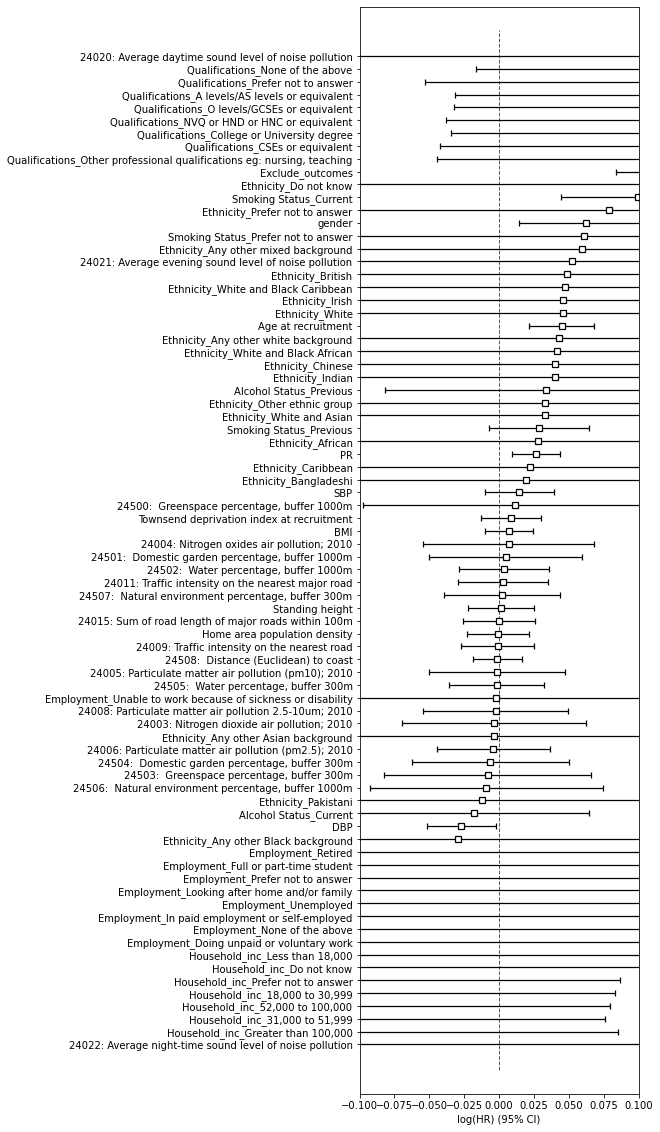

In [31]:
from lifelines import CoxPHFitter

df=pd.concat([df_input_stnd.drop(columns=['Alcohol Status_Never',
                                     'Smoking Status_Never',
                                     'Alcohol Status_Prefer not to answer',
                                     'birth_date',
                                          'Ethnicity_Asian or Asian British', 
                                          'Ethnicity_Black or Black British', 
                                          'Ethnicity_Mixed',
                                         "Exclude_baseline_MedCon"]),
              ukbd.df_label.drop(columns=['death','date_assessment'])],axis=1)
df.head()

cph = CoxPHFitter(penalizer=0.1, l1_ratio=1.0)
cph.fit(df, duration_col='outcome_months', event_col='outcomes')

cph.print_summary()
fig, ax=plt.subplots(figsize=(5,20))
cph.plot()
ax.set_xlim([-0.1,0.1])
plt.savefig(r'/home/mo/SPCA/Results/CPH.svg', bbox_inches='tight')

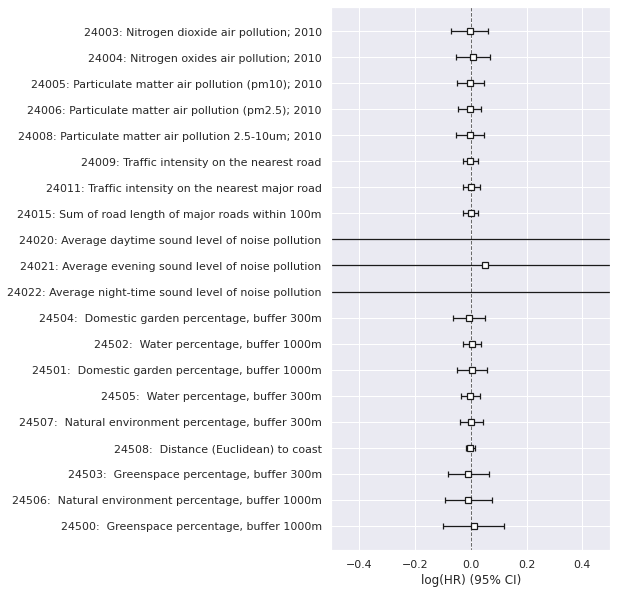

In [617]:
fig, ax=plt.subplots(figsize=(5,10))
cph.plot(columns=env_vars)
ax.set_xlim([-0.5,0.5])
plt.savefig(r'/home/mo/SPCA/Results/CPH_env_vars_oly.svg', bbox_inches='tight')

In [619]:
cph.summary.loc[env_vars].sort_values(by='coef',ascending=False)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
24020: Average daytime sound level of noise pollution,1.189887,3.286710,33.787234,-65.031875,67.411649,5.714991e-29,1.890198e+29,0.035217,0.971907,0.041110
24021: Average evening sound level of noise pollution,0.052180,1.053565,7.136369,-13.934847,14.039207,8.875089e-07,1.250691e+06,0.007312,0.994166,0.008441
"24500: Greenspace percentage, buffer 1000m",0.011485,1.011552,0.055689,-0.097663,0.120634,9.069543e-01,1.128212e+00,0.206241,0.836603,0.257386
24004: Nitrogen oxides air pollution; 2010,0.006763,1.006786,0.031125,-0.054239,0.067766,9.472052e-01,1.070115e+00,0.217302,0.827973,0.272344
"24501: Domestic garden percentage, buffer 1000m",0.004839,1.004851,0.027984,-0.050009,0.059687,9.512209e-01,1.061504e+00,0.172919,0.862715,0.213043
"24502: Water percentage, buffer 1000m",0.003643,1.003650,0.016458,-0.028613,0.035899,9.717920e-01,1.036551e+00,0.221349,0.824821,0.277847
24011: Traffic intensity on the nearest major road,0.002753,1.002756,0.016339,-0.029270,0.034776,9.711537e-01,1.035388e+00,0.168475,0.866209,0.207212
"24507: Natural environment percentage, buffer 300m",0.002028,1.002030,0.021186,-0.039495,0.043551,9.612747e-01,1.044513e+00,0.095719,0.923744,0.114435
24015: Sum of road length of major roads within 100m,-0.000170,0.999830,0.013231,-0.026102,0.025762,9.742359e-01,1.026097e+00,-0.012840,0.989756,0.014856


In [ ]:
import warnings
warnings.filterwarnings("error")
from lifelines.exceptions import ConvergenceWarning

from lifelines import CoxPHFitter

df=pd.concat([df_input_stnd.drop(columns=['Alcohol Status_Never',
                                     'Smoking Status_Never',
                                     'Alcohol Status_Prefer not to answer',
                                     'birth_date',
                                          'Ethnicity_Asian or Asian British', 
                                          'Ethnicity_Black or Black British', 
                                          'Ethnicity_Mixed',
                                         "Exclude_baseline_MedCon"]),
              ukbd.df_label.drop(columns=['death','date_assessment'])],axis=1)

penalizer_vals=np.linspace(0,0.0020,41)
#penalizer_vals=[0.0008]
cphs=[]
for penalizer in penalizer_vals:
    print(penalizer)
    try:
        cphp = CoxPHFitter(penalizer=penalizer, l1_ratio=1.0)
        cphp.fit(df, duration_col='outcome_months', event_col='outcomes')
        cphs.append(cphp)
    except ConvergenceWarning:
        cphs.append("ConvergenceError")
    except:
        cphs.append(np.nan)
    print(cphs)

0.0
['ConvergenceError']
5e-05
['ConvergenceError', <lifelines.CoxPHFitter: fitted with 379690 total observations, 364694 right-censored observations>]
0.0001
['ConvergenceError', <lifelines.CoxPHFitter: fitted with 379690 total observations, 364694 right-censored observations>, <lifelines.CoxPHFitter: fitted with 379690 total observations, 364694 right-censored observations>]
0.00015000000000000001
['ConvergenceError', <lifelines.CoxPHFitter: fitted with 379690 total observations, 364694 right-censored observations>, <lifelines.CoxPHFitter: fitted with 379690 total observations, 364694 right-censored observations>, 'ConvergenceError']
0.0002


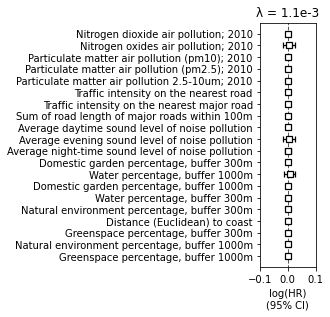

In [405]:
fig, ax=plt.subplots(figsize=(1,4.5))

#sig_vars_cph=list(cphs[1].summary.loc[env_vars].sort_values(by='coef',ascending=False).index)
cphs[22].plot(columns=env_vars)
plt.yticks(range(0,len(env_vars)),reversed([tick.split(":")[1].lstrip() for tick in env_vars]))
ax.set_xlim([-0.1,0.1])
ax.set_title("\u03BB = 1.1e-3")
ax.set_xlabel("log(HR)\n(95% CI)")
plt.savefig(r'/home/mo/SPCA/Results/CPH_temp1.svg', bbox_inches='tight')

In [324]:
env_vars_tidy=[tick.split(":")[1].lstrip() for tick in env_vars]

In [291]:
model_shrinkage=pd.DataFrame({penalizer_vals[i]: cphs[i].summary.loc[env_vars,"coef"] for i in range(len(penalizer_vals)) if (cphs[i] is not np.nan) and (cphs[i]!= "ConvergenceError") })

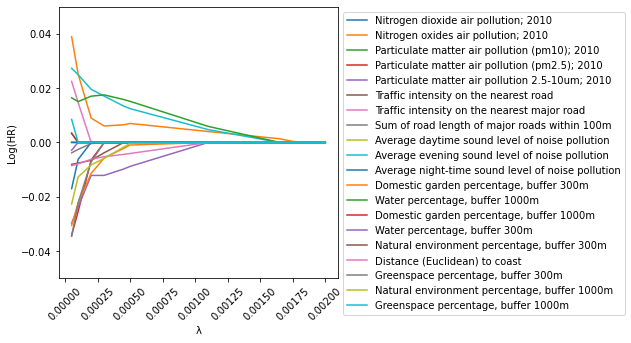

In [369]:
fig,ax=plt.subplots(figsize=(5,5))
model_shrinkage.T.plot(ax=ax)
ax.set_ylim(-0.05,0.05)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [tick.split(":")[1].lstrip() for tick in labels],bbox_to_anchor=(1,1))
plt.xticks(rotation=45)
plt.xlabel("\u03BB")
plt.ylabel("Log(HR)")
plt.savefig(r'/home/mo/SPCA/Results/Shrinkage.svg', bbox_inches='tight')

In [ ]:
fig, ax=plt.subplots(figsize=(7,5))
sns.lineplot(data=sum_results.set_index('lambda')[["Max #nonzero loadings","Max #variables in PCs","#PCs"]])#,"mean Corr","#PCs","Median #variables in PCs"
ax.tick_params(axis='both', which='major', labelsize=15,labelleft='on')
ax.legend(prop=dict(size=15))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_xlabel('Lambda',size=15)
plt.savefig(r'/home/mo/SPCA/Results/SPCS_pcsandLambda.svg', bbox_inches='tight')

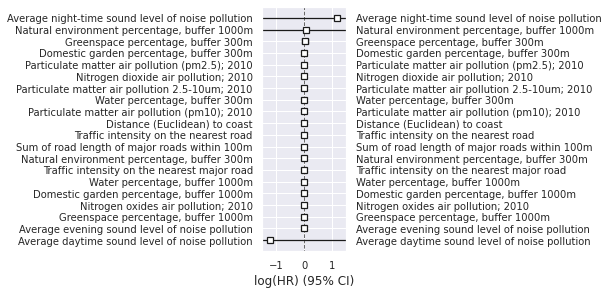

In [712]:
#sig_vars_cph=list(cph.summary[cph.summary['p']<0.01].sort_values(by='coef',ascending=False).index)
sig_vars_cph=list(cph.summary.loc[env_vars].sort_values(by='coef',ascending=False).index)

fig, ax=plt.subplots(figsize=(1.5,4.5))
cph.plot(sig_vars_cph,ax=ax)
plt.yticks(range(0,len(sig_vars_cph)),[tick.split(":")[1].lstrip() for tick in sig_vars_cph])
ax.set_xlim([-1.5,1.5])
ax.tick_params(axis='both', which='major', labelsize=10,labelright='on',labelleft='off')

plt.savefig(r'/home/mo/SPCA/Results/CoxSigs.svg', bbox_inches='tight')

In [841]:
table_new=cph.summary.loc[env_vars].copy()
table_new2=pd.DataFrame(columns=['results'],index=table_new.index)
for index in table_new.index:
    table_new2.loc[index,"results"]="{var1:0.2f} ({var2:0.2f}, {var3:0.2f})".format(var1=table_new.loc[index]["exp(coef)"],var2=table_new.loc[index]["exp(coef) lower 95%"],var3=table_new.loc[index]["exp(coef) upper 95%"])
    
vars_order=["24020: Average daytime sound level of noise pollution","24021: Average evening sound level of noise pollution","24022: Average night-time sound level of noise pollution",
           "24501:  Domestic garden percentage, buffer 1000m","24504:  Domestic garden percentage, buffer 300m","24500:  Greenspace percentage, buffer 1000m","24503:  Greenspace percentage, buffer 300m",
           "24506:  Natural environment percentage, buffer 1000m","24507:  Natural environment percentage, buffer 300m",
           "24502:  Water percentage, buffer 1000m","24505:  Water percentage, buffer 300m",
            "24508:  Distance (Euclidean) to coast",
            "24003: Nitrogen dioxide air pollution; 2010","24004: Nitrogen oxides air pollution; 2010","24005: Particulate matter air pollution (pm10); 2010","24008: Particulate matter air pollution 2.5-10um; 2010",
            "24006: Particulate matter air pollution (pm2.5); 2010",
            "24015: Sum of road length of major roads within 100m",
            "24011: Traffic intensity on the nearest major road","24009: Traffic intensity on the nearest road"]
table_new2.loc[vars_order[0:]]

,results
covariate,
24020: Average daytime sound level of noise pollution,"3.29 (0.00, 189019763611347553283616014336.00)"
24021: Average evening sound level of noise pollution,"1.05 (0.00, 1250691.42)"
24022: Average night-time sound level of noise pollution,"0.29 (0.00, 12094355315455355530770382848.00)"
"24501: Domestic garden percentage, buffer 1000m","1.00 (0.95, 1.06)"
"24504: Domestic garden percentage, buffer 300m","0.99 (0.94, 1.05)"
"24500: Greenspace percentage, buffer 1000m","1.01 (0.91, 1.13)"
"24503: Greenspace percentage, buffer 300m","0.99 (0.92, 1.07)"
"24506: Natural environment percentage, buffer 1000m","0.99 (0.91, 1.08)"
"24507: Natural environment percentage, buffer 300m","1.00 (0.96, 1.04)"
